# Showcase how to run a simulation of virtual Argo floats

Requirements:
- Velocity fields from: GLOBAL-ANALYSIS-FORECAST-PHY-001-024
- Python libraries:

    ```bash
    pip install progressbar cgen
    ```

***
Script prepared by [Kevin Balem](http://github.com/quai20) (Feb. 2020)

This work is part and was supported by the following projects:
<div>
<img src="https://avatars1.githubusercontent.com/u/58258213?s=460&v=4" width="70"/>
<img src="https://user-images.githubusercontent.com/17851004/83142990-8fe60380-a0f1-11ea-85c1-f7b1d343be88.jpg" width="200"/>
<img src="https://www.umr-lops.fr/var/storage/images/_aliases/logo_main/medias-ifremer/medias-lops/logos/logo-lops-2/1459683-4-fre-FR/Logo-LOPS-2.png" width="70"/>
</div>

In [7]:
# !pip install progressbar
# !pip install cgen

In [6]:
import virtualargofleet as vaf

import matplotlib.pyplot as plt
%matplotlib notebook
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.patches as mpatches
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=[0.4,0.6,0.7])

In [2]:
#CHAMPS DE VISTESSE
filenames = {'U':"/export/home/MOUNT/armor3d/201?/*.nc",
             'V':"/export/home/MOUNT/armor3d/201?/*.nc"}
variables = {'U':'ugo','V':'vgo'}
dimensions = {'time': 'time', 'depth':'depth', 'lat': 'latitude', 'lon': 'longitude'}

In [3]:
# DEFINE THE VELOCITY FIELD OBJECT
# USAGE : obj=vaf.velocityfield(ds=filenames,var=variables,dim=dimensions,isglobal=0 or 1) 
tfield=vaf.velocityfield(ds=filenames,var=variables,dim=dimensions,isglobal=0)

INFO: Unable to locate chunking hints from dask, thus estimating the max. chunk size heuristically. Please consider defining the 'chunk-size' for 'array' in your local dask configuration file (see http://oceanparcels.org/faq.html#field_chunking_config and https://docs.dask.org).


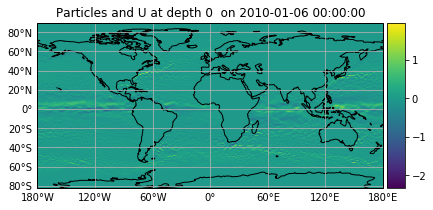

In [4]:
tfield.plot()

In [15]:
# Initiate some Argo float infos
#Number of float we want to advect
nfloats=10

#Then we must define numpy array (size nfloats) for lat,lon,depth and time
lat0=0.00
lon0=240.00
t0=np.datetime64('2015-01-01')
lon=np.random.uniform(lon0-0.0, lon0+0.0, size=nfloats)
lat=np.random.uniform(lat0-1.0, lat0+1.0, size=nfloats)
depth=np.linspace(1.0,1.0,nfloats) #1m depth
ti=np.empty(nfloats,dtype='datetime64[D]')
ti[:]=t0

# DEFINE THE FLOAT OBJECT
# USAGE : obj=virtualfloat(lat=lat_array,lon=lon_array,depth=depth_array,
#                          time=time_array,vfield=velocity_field_object) 
myfloats=vaf.virtualfleet(lat=lat,lon=lon,depth=depth,time=ti,vfield=tfield)

<IPython.core.display.Javascript object>


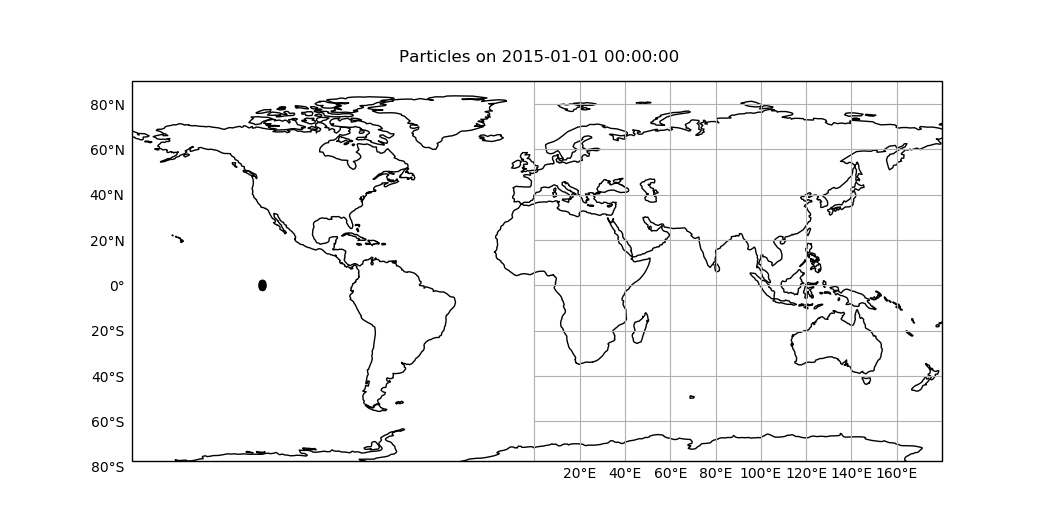

In [16]:
myfloats.plotfloat()

In [17]:
# START THE ADVECTION
# USAGE : float_object.advect(duration=days,dt_run=hours,dt_out=hours,output_file='my_advection_nXX.nc')
myfloats.simulate(duration=365,dt_run=1./12,dt_out=24,output_file='test_from_home.nc')

INFO: Compiled ArgoParticleArgoVerticalMovementAdvectionRK4 ==> /tmp/parcels-500721/f23d252aee5a42a6f501d49a2f16fa16_0.so
INFO: Temporary output files are stored in out-EZUOKLYA.
INFO: You can use "parcels_convert_npydir_to_netcdf out-EZUOKLYA" to convert these to a NetCDF file during the run.
  3% (950400.0 of 31536000.0) |          | Elapsed Time: 0:00:57 ETA:   1:17:56WARNING: File /export/home/MOUNT/armor3d/2015/dataset-armor-3d-rep-weekly_20150128T1200Z_P20190301T0000Z.nc could not be decoded properly by xarray (version 0.12.1).
         It will be opened with no decoding. Filling values might be wrongly parsed.
  5% (1728000.0 of 31536000.0) |         | Elapsed Time: 0:01:01 ETA:   0:12:30

KeyboardInterrupt: 

In [ ]:
# EXAMPLE FOR PLOTTING RESULTS
simu=xr.open_dataset('test_from_home.nc')
velo=xr.open_dataset('/home/datawork-lops-oh/somovar/WP1/data/GLOBAL-ANALYSIS-FORECAST-PHY-001-024/20191205_global-analysis-forecast-phy-001-024.nc')

pr1=ccrs.PlateCarree()
pr2=ccrs.LambertConformal(-72,35,false_easting=0.0, false_northing=0.0, secant_latitudes=None, standard_parallels=None, cutoff=-30)

fig=plt.figure()
ax3 = fig.add_subplot(1,1,1,projection=pr2)
ax3.add_feature(land_feature, edgecolor='black')
ax3.set_extent([simu.lon.min()-10, simu.lon.max()+10, simu.lat.min()-10, simu.lat.max()+10])

ax3.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle=':')

velo['zos'][0][:][:].plot(cmap=plt.cm.coolwarm,
                          cbar_kwargs={'orientation': 'horizontal', 'shrink':0.5, 'pad':0.1},
                          transform=pr1)

for i in simu.traj:
    temp=simu.isel(traj=i).sortby('time')
    ax3.plot(temp['lon'][0],temp['lat'][0],'k.',transform=pr1)
    ax3.plot(temp['lon'],temp['lat'],linewidth=2,transform=pr1)


ax3.plot(lon0,lat0,'or','markersize',4,transform=pr1)
ax3.add_patch(mpatches.Rectangle(xy=[simu.lon.min()-8, simu.lat.min()-8], width=(simu.lon.max()-simu.lon.min()+16), height=(simu.lat.max()-simu.lat.min()+16),
                                    edgecolor='k',facecolor='none',linestyle=':',transform=pr1))

plt.title("")